In [1]:
import pandas as pd
import numpy as np
from scipy import  stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csc_matrix, hstack
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from matplotlib_venn import venn2

In [2]:
def optimize_lgb_clf(X, y, seed, cv, metric, greater_is_better, num_boost_round, early_stopping_rounds, show,**my_scorer):
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
    from sklearn.metrics import make_scorer
    
    '''
    оптимизирует гиперпараметры lightgbm с ранней остановкой и возможностью задать кастомную метрику качества
    
    параметры:
        1) X -признаки
        2) y - таргет
        3) seed - генератор случайных чисел
        4) cv - схема валидации
        5) metric - оптимизируемая метрика
        6) greater_is_better - направление улучшения значений метрики
        7) num_boost_round - ранняя остановка
        8) early_stopping_rounds - ранняя остановка
        9) show - показывать процесс оптимизации
        10) кастомная метрика (необязательный аргумент)
    
    возвращает:
        1) оптимальное значение метрики
        2) оптимальные гиперпараметры    
    '''
    
    
        
    ###############################################################################################################    
    def _fit_grid(X, y, seed, cv, metric, greater_is_better, grid, num_boost_round, early_stopping_rounds, show):
        if greater_is_better:   
            best_metric = 0
        else:
            best_metric = np.inf            
        for parameters in tqdm_notebook(ParameterGrid(grid)):
            estimator = LGBMClassifier(random_state = seed, **params)
            metrics = []
            try:
                for tr_idx, val_idx in cv.split(X):
                    data_tr = lgb.Dataset(X[tr_idx], label=y[tr_idx])
                    data_val = lgb.Dataset(X[val_idx], label=y[val_idx])
                    estimator.train(parameters,
                                    data_tr,
                                    valid_sets=data_val,
                                    num_boost_round=num_boost_round,
                                    early_stopping_rounds=early_stopping_rounds)
                    if metric =='roc_auc':
                        metrics.append(roc_auc_score(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                    if metric == 'f1':
                        metrics.append(f1_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'accuracy':
                        metrics.append(accuracy_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'precision':
                        metrics.append(precision_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'recall':
                        metrics.append(recall_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom_prob':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                        
                mean_metric = np.mean(metrics)
                if greater_is_better:                    
                    if mean_metric>best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                else:
                    if mean_metric<best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                    
            except:
                for tr_idx, val_idx in cv.split(X, y):
                    data_tr = lgb.Dataset(X[tr_idx], label=y[tr_idx])
                    data_val = lgb.Dataset(X[val_idx], label=y[val_idx])
                    estimator.train(parameters,
                                    data_tr,
                                    valid_sets=data_val,
                                    num_boost_round=num_boost_round,
                                    early_stopping_rounds=early_stopping_rounds)
                    if metric =='roc_auc':
                        metrics.append(roc_auc_score(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                    if metric == 'f1':
                        metrics.append(f1_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'accuracy':
                        metrics.append(accuracy_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'precision':
                        metrics.append(precision_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'recall':
                        metrics.append(recall_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom_prob':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                        
                mean_metric = np.mean(metrics)
                if greater_is_better:                    
                    if mean_metric>best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                else:
                    if mean_metric<best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                        
        return (best_metric, best_params)
    ##########################################################################################################################
    max_depths = np.arange(3, 11).tolist()
    num_leaves = [2**i for i in range(1, 10)]
    min_child_samples = [20, 50, 100, 500, 1000]
    
    grid1 = {'max_depth' : max_depths,\
            'num_leaves' : num_leaves,\
            'min_child_samples' : min_child_samples,\
            'n_estimators' : [500], 'learning_rate' :[.05]}
    
    best_metric, best_params = _fit_grid(X = X, y = y, seed = seed, cv = cv, metric = metric,\
                                         greater_is_better = greater_is_better,\
                                         grid = grid1, num_boost_round = num_boost_round,\
                                         early_stopping_rounds = early_stopping_rounds, show = show) 
    
    grid2 = {'max_depth' : [best_params['max_depth']-1, best_params['max_depth'], best_params['max_depth']+1],\
            'num_leaves' : [best_params['num_leaves']-8, best_params['num_leaves'], best_params['num_leaves']+8],\
            'min_child_samples' : [best_params['min_child_samples']-10, best_params['min_child_samples'],\
                                   best_params['min_child_samples']+10],\
            'n_estimators' : [500], 'learning_rate' :np.linspace(.01, .06, 10),\
            'subsample' : [.5, .7, 1], 'colsample_bytree' : [.5, .7, 1]}
    best_metric2, best_params2 = _fit_grid(X = X, y = y, seed = seed, cv = cv, metric = metric,\
                                         greater_is_better = greater_is_better,\
                                         grid = grid2, num_boost_round = num_boost_round,\
                                         early_stopping_rounds = early_stopping_rounds, show = show) 
    
    return (best_metric2, best_params2)
    


class FeatureSelector():
    
    '''
    класс, реализующий отбор признаков
    
    гиперпараметры:
        1) estimator - модель, с помощью которой осуществляется отбор признаков
        2) cv - схема валидации
        3) metric - оптимизируемая метрика
        4) use_recursion - использовать рекурсию
        5) fill_value - значение, которым заполняются np.nan
        6) use_value - использовать отбор значений признаков
        7) show_progress - печатать прогресс
    '''
    
    def __init__(self, estimator, cv, metric, use_recursion, fill_value, use_value, show_progress):
        self.estimator = estimator
        self.cv = cv
        self.use_recursion = use_recursion
        self.metric = metric
        self.fill_value = fill_value
        self.use_value = use_value
        self.show_progress = show_progress
        
    def fit(self, X, y):
        '''
        1) считается валидация каждого признака+значений признаков
        2) жадным способом добавляются признаки/значения 
        3) если используется рекурсия, добавляется рекурсивный отбор
            
        '''
        
        try:
            X[np.isnan(X)] = self.fill_value
        except:
            pass
        
        scores = []
        for col_idx in tqdm_notebook(range(X.shape[1])):
            series = X[:, col_idx]
            if self.use_value is None:
                scores.append((col_idx, None,\
                               cross_validate(self.estimator, series.reshape(-1,1), y,\
                                              scoring =self.metric, cv = self.cv)['test_score'].mean()))
            else:                                
                if col_idx in self.use_value:
                    unique_values = np.unique(series[~np.isnan(series)])
                    for val in tqdm_notebook(unique_values):
                        _x = (series == val).astype(int).reshape(-1,1)
                        scores.append((col_idx, val, cross_validate(self.estimator, _x,\
                                              y, scoring =self.metric, cv = self.cv)['test_score'].mean()))
                else:
                    scores.append((col_idx, None,\
                                   cross_validate(self.estimator, series.reshape(-1,1), y,\
                                                  scoring =self.metric, cv = self.cv)['test_score'].mean()))
                
        order = []
        for row in sorted(scores, key=lambda x: x[-1], reverse = True):
            order.append((row[0], row[1]))
                
        D_selected = defaultdict(list)
        best_score = .5
        best_features = []
        to_drop = []
        
        for element in tqdm_notebook(order):            
            column, value = element[0], element[1]

            if value is not None:
                D_selected[column].append(value)
                L = []
                for feat, values in D_selected.items():
                    L.append(list(map(lambda x: x if x in values else -1, X[:, feat])))
                xcurr1 = np.column_stack(L)
            else:
                current_features = best_features + [column]
                xcurr2 = X[:, current_features]
            try:
                xcurr = csc_matrix(hstack([xcurr1, xcurr2]))
            except:
                try:
                    xcurr = xcurr1
                except:
                    xcurr = xcurr2
                    
            current_score = cross_validate(self.estimator, xcurr, y,\
                                           scoring =self.metric, cv = self.cv)['test_score'].mean()
            if current_score>best_score:
                best_score = current_score
                if self.show_progress:
                    print('new best score = {}'.format(best_score))
                if value is not None:
                    pass
                else:
                    best_features = current_features
            else:
                if value is not None:
                    D_selected[column] = [val for val in D_selected[column] if val != value]
                    to_drop.append((column, value))
                else:
                    to_drop.append((column, value)) 
                    
        if self.use_recursion:
            to_drop_before = to_drop
            to_drop_after = []
            while True:
                for element in tqdm_notebook(to_drop_before):            
                    column, value = element[0], element[1]
                    if value is not None:
                        D_selected[column].append(value)
                        L = []
                        for feat, values in D_selected.items():
                            L.append(list(map(lambda x: x if x in values else -1, X[:, feat])))
                        xcurr1 = np.column_stack(L)
                    else:
                        current_features = best_features + [column]
                        xcurr2 = X[:, current_features]
                    try:
                        xcurr = csc_matrix(hstack([xcurr1, xcurr2]))
                    except:
                        try:
                            xcurr = xcurr1
                        except:
                            xcurr = xcurr2

                    current_score = cross_validate(self.estimator, xcurr, y,\
                                                   scoring =self.metric, cv = self.cv)['test_score'].mean()
                    if current_score>best_score:
                        best_score = current_score
                        if self.show_progress:
                            print('new best score = {}'.format(best_score))
                        if value is not None:
                            pass
                        else:
                            best_features = current_features
                    else:
                        if value is not None:
                            D_selected[column] = [val for val in D_selected[column] if val != value]
                            to_drop_after.append((column, value))
                        else:
                            to_drop_after.append((column, value)) 
                            
                if len(to_drop_after) == len(to_drop_before):
                    break
                else:
                    to_drop_before= to_drop_after
                    to_drop_after = []
        
        self.D_selected = D_selected
        self.best_features = best_features
        self.best_score = best_score
        return self
        
    def transform(self, X):
        '''
        в матрице X оставляются отобранные признаки+значения признаков
        '''
        try:
            X[np.isnan(X)] = self.fill_value
        except:
            pass
        if len(self.best_features) !=0:
            x1 = X[:, self.best_features]
        else:
            x1 = None
        if len(list(self.D_selected.keys())) !=0:
            L=[]
            for k, v in self.D_selected.items():
                L.append(list(map(lambda x: x if x in v else self.fill_value, X[:, k])))
            x2 = np.column_stack(L)
        else:
            x2 = None
            
        if (x1 is not None) & (x2 is not None):
            _X = csc_matrix(hstack([f1, f2]))
        if (x1 is not None) & (x2 is None):
            _X = x1
        if (x1 is None) & (x2 is not None):
            _X = x2
        return _X  
    
    def best_score(self):
        return self.best_score

In [3]:
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]
SEED = 13

df_tr = pd.read_csv('train_sessions.csv', parse_dates = times).set_index('session_id').sort_values('time1')
df_te = pd.read_csv('test_sessions.csv', parse_dates = times).set_index('session_id')
y_tr = df_tr['target']

дата = 201301, появлений Элис = 0
дата = 201302, появлений Элис = 61
дата = 201303, появлений Элис = 0
дата = 201304, появлений Элис = 38
дата = 201305, появлений Элис = 0
дата = 201306, появлений Элис = 0
дата = 201307, появлений Элис = 0
дата = 201308, появлений Элис = 0
дата = 201309, появлений Элис = 377
дата = 201310, появлений Элис = 0
дата = 201311, появлений Элис = 446
дата = 201312, появлений Элис = 134
дата = 201401, появлений Элис = 129
дата = 201402, появлений Элис = 410
дата = 201403, появлений Элис = 400
дата = 201404, появлений Элис = 302


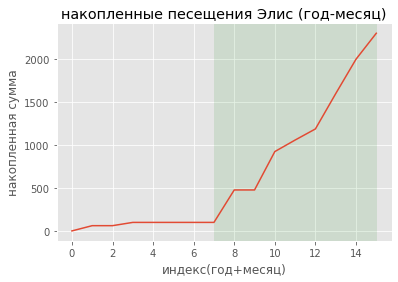

In [4]:
df_tr['ym'] = df_tr['time1'].dt.year*100+df_tr['time1'].dt.month
target_by_ym = df_tr.groupby('ym')['target'].sum()
for _ym, _total_alice in target_by_ym.items():
    print('дата = {}, появлений Элис = {}'.format(_ym, _total_alice))
    

target_by_ym.cumsum().reset_index(drop = True).plot()
plt.title('накопленные песещения Элис (год-месяц)')
plt.xlabel('индекс(год+месяц)')
plt.ylabel('накопленная сумма')
plt.axvspan(7, 15, color = 'green', alpha = .1)
plt.show()    


### актуальный период начинается после 201309, когда активность Элис возобновляется

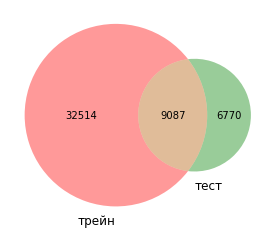

In [5]:
sites_unique_tr = pd.Series(df_tr[sites].values.flatten()).dropna().unique()
sites_unique_te = pd.Series(df_te[sites].values.flatten()).dropna().unique()

set_sites_tr = set(sites_unique_tr)
set_sites_te = set(sites_unique_te)

venn2([set_sites_tr, set_sites_te], ('трейн', 'тест'))

plt.show()

### оставим в трейне сайты, которые посещались Элис+присутствуют в тест части, чтобы не переобучаться на трейн

In [6]:
# оставляем в трейне сайты, которые были посещены Элис + присутствуют в тест части
sites_to_use = np.intersect1d(pd.Series(df_tr[sites][y_tr==1].values.flatten()).dropna().unique(),\
                              pd.Series(df_te[sites].values.flatten()).dropna().unique())
sites_tr = df_tr[sites].applymap(lambda x: x if x in sites_to_use else -1)

### дата: день года, неделя года, год, месяц, день, день недели, час(оставим данные из тест части)

In [7]:
D_ts = {}
for name, _df in zip(('train', 'test'), (df_tr, df_te)):
    start = _df[times].min(1).dt.round('H')
    
    D_ts[name] = pd.concat([start.dt.dayofyear,
                            start.dt.weekofyear,
                            start.dt.quarter,
                            start.dt.year,
                            start.dt.month,
                            start.dt.day,
                            start.dt.dayofweek,
                            start.dt.hour], 1)
    
for col in D_ts['test'].columns:
    values_to_use = D_ts['test'][col].dropna().unique()
    D_ts['train'][col] = D_ts['train'][col].apply(lambda x:x if x in values_to_use else -1)

In [8]:
# модели
logit_clf = LogisticRegression(random_state = SEED)
lgb_clf = LGBMClassifier(random_state = SEED)

# доля отложенной части
HOLDOUT_SHARE = .1
idx_split = np.int32(np.around(len(y_tr)*(1-HOLDOUT_SHARE)))

In [9]:
# время
_X_ts_tr = D_ts['train'].values
# ohe
encoder = OneHotEncoder(handle_unknown='ignore')
_X_ts_ohe_tr = encoder.fit_transform(_X_ts_tr)
# сайты
_X_sites_tr = sites_tr
# таргет
_y_tr = np.array(y_tr)

In [14]:
print('{} | {} | {} | {:<6} | {:<6} | {:<6} | {:<6}'.format('nfolds', 'ngram_range',\
                                                            'max_features', 'lgb cv', 'logit cv', 'lgb ho', 'logit ho'))
print('---------------------------------------------------------------------------')

maxfeatures_range = (1e2, 1e3, 1e4, 1e5, 5e5)
ngram_range_range = ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5))
cv_sites = []
for nfolds in [3, 5, 7, 9]:
    TSCV = TimeSeriesSplit(nfolds)
    for _ngram_range in ngram_range_range:    
        for i, _max_features in enumerate(maxfeatures_range):
            vec = TfidfVectorizer(ngram_range = _ngram_range, max_features = np.int32(_max_features))
            tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                           .astype(str).apply(lambda x: '_'.join(x), axis = 1))
            tfidf_tr = tfidf_full[:len(y_tr)]
            cv_lgb = cross_validate(lgb_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                            scoring = 'roc_auc', cv = TSCV)['test_score'].mean()
            lgb_clf.fit(tfidf_tr[:idx_split], _y_tr[:idx_split])
            lgb_holdout = roc_auc_score(_y_tr[idx_split:], lgb_clf.predict_proba(tfidf_tr[idx_split:])[:, 1])
            
            cv_logit = cross_validate(logit_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                            scoring = 'roc_auc', cv = TSCV)['test_score'].mean()
            logit_clf.fit(tfidf_tr[:idx_split], _y_tr[:idx_split])
            logit_holdout = roc_auc_score(_y_tr[idx_split:], logit_clf.predict_proba(tfidf_tr[idx_split:])[:, 1])
            
            cv_sites.append((nfolds, _ngram_range, _max_features,cv_lgb,cv_logit))
            
            
            
            print('{:<6} | {:<11} | {:<12} | {:.4f} | {:.6f} | {:.4f} | {:.4f}'.format(nfolds, str(_ngram_range),\
                                                                     np.int32(_max_features),\
                                                                     cv_lgb, cv_logit,\
                                                                     lgb_holdout, logit_holdout))

nfolds | ngram_range | max_features | lgb cv | logit cv | lgb ho | logit ho
---------------------------------------------------------------------------
3      | (1, 1)      | 100          | 0.8715 | 0.845968 | 0.9197 | 0.9229
3      | (1, 1)      | 1000         | 0.8917 | 0.873580 | 0.9265 | 0.9226
3      | (1, 1)      | 10000        | 0.8974 | 0.895382 | 0.9294 | 0.9292
3      | (1, 1)      | 100000       | 0.9021 | 0.898661 | 0.9260 | 0.9291
3      | (1, 1)      | 500000       | 0.9021 | 0.898661 | 0.9260 | 0.9291
3      | (1, 2)      | 100          | 0.8851 | 0.863838 | 0.9164 | 0.9143
3      | (1, 2)      | 1000         | 0.8964 | 0.870675 | 0.9245 | 0.9222
3      | (1, 2)      | 10000        | 0.8953 | 0.893099 | 0.9279 | 0.9288
3      | (1, 2)      | 100000       | 0.9011 | 0.899790 | 0.9271 | 0.9329
3      | (1, 2)      | 500000       | 0.9042 | 0.902313 | 0.9302 | 0.9344
3      | (1, 3)      | 100          | 0.8809 | 0.863408 | 0.9252 | 0.9190
3      | (1, 3)      | 1000       

KeyboardInterrupt: 

### отберем признаки для разного числа фолдов (3-10) и разных моделей (logit, lgb). каждые признаки засабмитим и проверим лидерборд
* TfidfVectorizer(ngram_range = (1, 2), max_features = 500000)

In [15]:
# tfidf
vec = TfidfVectorizer(ngram_range = (1, 2), max_features = 500000)
nfolds_range = np.arange(3, 11)

In [16]:

# for nfolds in tqdm_notebook(nfolds_range):
    
#     # валидация
#     TSCV = TimeSeriesSplit(nfolds)    
    
#     # трансформируем сайты
#     tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
#                                            .astype(str).apply(lambda x: '_'.join(x), axis = 1))
#     tfidf_tr = tfidf_full[:len(y_tr)]
    
#     # признаки
#     _logit_X_tr = csc_matrix(hstack([_X_ts_ohe_tr, tfidf_tr]))
#     _lgb_X_tr = csc_matrix(hstack([_X_ts_tr, tfidf_tr]))
    
#     # отбираем признаки logit
#     logit_selector = FeatureSelector(estimator = logit_clf, cv = TSCV,\
#                                      metric = 'roc_auc', use_recursion = True,\
#                                      fill_value = -1, use_value = None,\
#                                      show_progress = True)
#     logit_selector.fit(_logit_X_tr[:idx_split], _y_tr[:idx_split])
#     X_selected_logit = logit_selector.transform(_logit_X_tr)
#     with open(f'logit_selector_{nfolds}.pickle', 'wb') as f:
#         pickle.dump(X_selected_logit, f)
        
#     # отбираем признаки lgb
#     lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
#                                      metric = 'roc_auc', use_recursion = True,\
#                                      fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
#                                      show_progress = True)
#     lgb_selector.fit(_lgb_X_tr[:idx_split], _y_tr[:idx_split])
#     X_selected_lgb = lgb_selector.transform(_lgb_X_tr)
#     with open(f'lgb_selector_{nfolds}.pickle', 'wb') as f:
#         pickle.dump(X_selected_lgb, f)

In [ ]:
# валидация
TSCV = TimeSeriesSplit(3)    
    
# трансформируем сайты
tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                 .astype(str).apply(lambda x: '_'.join(x), axis = 1))
tfidf_tr = tfidf_full[:len(y_tr)]
    
# признаки
_logit_X_tr = csc_matrix(hstack([_X_ts_ohe_tr, tfidf_tr]))
_lgb_X_tr = csc_matrix(hstack([_X_ts_tr, tfidf_tr]))
    
# отбираем признаки logit
logit_selector = FeatureSelector(estimator = logit_clf, cv = TSCV,\
                                 metric = 'roc_auc', use_recursion = True,\
                                 fill_value = -1, use_value = None,\
                                 show_progress = True)
logit_selector.fit(_logit_X_tr[:idx_split], _y_tr[:idx_split])
X_selected_logit = logit_selector.transform(_logit_X_tr)
with open('logit_selector_3.pickle', 'wb') as f:
    pickle.dump(X_selected_logit, f)
        
# отбираем признаки lgb
lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = True,\
                               fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
                               show_progress = True)
lgb_selector.fit(_lgb_X_tr[:idx_split], _y_tr[:idx_split])
X_selected_lgb = lgb_selector.transform(_lgb_X_tr)
with open('lgb_selector_3.pickle', 'wb') as f:
    pickle.dump(X_selected_lgb, f)

In [ ]:
# best_metric, best_params = optimize_lgb_clf(X_selected_logit, y_tr, seed=SEED, TimeSeriesSplit(3),\
#                                             metric = 'roc_auc', greater_is_better=True,\
#                                             num_boost_round=5000, early_stopping_rounds=100, show = True)